# Generate Graph Models for Statistical Testing

In [14]:
import networkx as nx
import networkit as nk # for network generation and for use in the betti_numbers function eventually
import numpy as np # matrix calculations and data generation
from sklearn.model_selection import ParameterSampler # sampling a parameter grid for simulation
import time # for time benchmarking in simulation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # analzying and visualizing the results

np.random.seed(122)


## SBM Growth Model (by Color) (Slow)

In [15]:
def generate_SBM_growth(P:np.ndarray) -> nx.Graph:
    """
    Generate iterative SBM of size n given a set of vertex edge pair probabilities
    
    :param P: n*n edge probability matrix
    """
    n = P.shape[0]
    
    # add the first node
    G = nx.Graph()
    G.add_node(0)

    for i in range(1, n):

        # add the node to the graph, then check it against the existing nodes to see if we will add an edge or not
        G.add_node(i)

        for j in range(0, i):
            # choose rand num U(0, 1)
            runif = np.random.random()

            # we ensure we only look at the upper triangular portion of P since it is upper triangular
            if runif <= P[j, i]:
                # there is an edge
                G.add_edge(i, j)

    return G

## SBM Model (Static) (Faster)

In [16]:
def generate_SBM_static(P:np.ndarray):
    """
    P is an upper-triangular square probability matrix.
    """
    # generate the adjacency matrix based on edge probabilities in P
    A = (np.random.random(P.shape) < P).astype(int)
    # make the matrix symmetric
    full_A = np.maximum(A, A.T)
    # convert to a networkx graph
    return nx.Graph(full_A)


## Generate Probability Matrix

In [17]:
def generate_prob_matrix(n:int, c:int, x_sim:float, x_diff:float, sigma_eps:float):

    # possible color choices
    color_choices = np.array(range(c))
    # assign nodes a color uniformly at random
    color_arr = np.random.choice(color_choices, size=n, replace=True)

    # compute the error terms
    Epsilon = np.random.normal(0, sigma_eps, (n, n))

    # compute the fixed similarities
    #X = np.array([[x_sim if color_arr[i]==color_arr[j] else x_diff for i in range(n)] for j in range(n)])
    color_mask = (color_arr[:, None] == color_arr[None, :])
    X = np.where(color_mask, x_sim, x_diff)

    # use the sigmoid function to transform the result into a valid probability matrix
    sigmoid = lambda t: 1 / (1 + np.exp(-t))
    return np.triu(sigmoid(X + Epsilon), 1), list(color_arr)

## Compile Simulation Logic

In [18]:
def placeholder_func(G:nk.Graph, colors:list) -> float:
    # for now, just return a random p value
    # for time benchmarking, use sleep to estimate maximum time to run
    # time.sleep(8)
    return np.random.random()

def simulate(x_sim, x_diff, n, c, sigma_eps, generation_method="static"):
    # uncomment this when we actually pass in our true function
    #P, colors = generate_prob_matrix(n, c, x_sim, x_diff, sigma_eps)
    #if generation_method == "growth":
    #    G = generate_SBM_growth(P)
    #elif generation_method == "static":
    #    G = generate_SBM_static(P)
    #else: raise ValueError(f"{generation_method} is invalid generation method.")
    #pval = placeholder_func(nk.nxadapter.nx2nk(G), colors)

    pval = np.random.random()
    return pval
    

## Parameter Grid

In [19]:
param = {
    'x_sim': range(10, 21), # we want to test when x_sim > x_diff as well as x_sim <= x_diff
    'x_diff': range(1, 21),
    'n': range(10, 300, 20),
    'c': range(2, 10),
    'sigma_eps': range(0, 10), # standard deviation of the random noise
    'generation_method': ['growth', 'static']
    }

grid = ParameterSampler(param, n_iter=100, random_state=42)

## Simulate

In [26]:
n_validations = 1000 # must be sufficiently large, especially for such a high-dimensional hypergrid parameter hypergrid
alpha = 0.05

results = {}

for params in grid:
    param_key = tuple(sorted(params.items()))

    # we will store the results of the tests themselves for each iteration, 
    # and then calculate the proportion that were correct
    results[param_key] = [0, []]
    
    for _ in range(n_validations):
        pval = simulate(**params)
        results[param_key][1].append(pval)
    
    results[param_key][0] = sum([elem < alpha for elem in results[param_key][1]]) / n_validations

# results will give the proportion of graphs correctly identified as significant
l = 5 # print first 5
for key, value in results.items():
    if l == 0: break
    else: l -= 1
    print(f"Params: {key}; result: {value[0]}")

Params: (('c', 3), ('generation_method', 'static'), ('n', 210), ('sigma_eps', 4), ('x_diff', 8), ('x_sim', 11)); result: 0.048
Params: (('c', 3), ('generation_method', 'static'), ('n', 290), ('sigma_eps', 9), ('x_diff', 14), ('x_sim', 19)); result: 0.054
Params: (('c', 7), ('generation_method', 'static'), ('n', 30), ('sigma_eps', 2), ('x_diff', 19), ('x_sim', 10)); result: 0.052
Params: (('c', 5), ('generation_method', 'static'), ('n', 250), ('sigma_eps', 8), ('x_diff', 2), ('x_sim', 17)); result: 0.058
Params: (('c', 3), ('generation_method', 'static'), ('n', 110), ('sigma_eps', 1), ('x_diff', 5), ('x_sim', 14)); result: 0.044


## Analyze Results

In [27]:
keys, values = list(results.keys()), list(results.values())

key_list = [list(key) for key in keys]
names = ['color_num', 'generation_method', 'node_num', 'sigma_eps', 'x_diff', 'x_sim', 'true_positive_prop'] + [f"pval_iter{i}" for i in range(n_validations)]
listified = [[k[1] for k in key_list[i]] + [values[i][0]] + values[i][1] for i in range(len(keys))]
listified

names_list = [names] * len(listified)
data = [dict(zip(names, l)) for l in listified]
print("Head:")
data[:5]

Head:


[{'color_num': 3,
  'generation_method': 'static',
  'node_num': 210,
  'sigma_eps': 4,
  'x_diff': 8,
  'x_sim': 11,
  'true_positive_prop': 0.048,
  'pval_iter0': 0.6655338236279369,
  'pval_iter1': 0.2797585302067521,
  'pval_iter2': 0.7990789258933598,
  'pval_iter3': 0.46930180187294124,
  'pval_iter4': 0.2891737406141658,
  'pval_iter5': 0.6733594863242589,
  'pval_iter6': 0.6005416618914005,
  'pval_iter7': 0.20599450662377516,
  'pval_iter8': 0.18121225782476735,
  'pval_iter9': 0.9552988233771694,
  'pval_iter10': 0.041227865765048444,
  'pval_iter11': 0.9085824672481098,
  'pval_iter12': 0.9008559943209872,
  'pval_iter13': 0.45925236024847393,
  'pval_iter14': 0.8986655349490025,
  'pval_iter15': 0.9369561935782611,
  'pval_iter16': 0.8447913384149336,
  'pval_iter17': 0.7382518254544223,
  'pval_iter18': 0.5602237199724279,
  'pval_iter19': 0.10929469722884566,
  'pval_iter20': 0.3027276327438303,
  'pval_iter21': 0.36085510346970084,
  'pval_iter22': 0.6585576161961285,
  

In [28]:
df = pd.DataFrame(data)
df.head()

,color_num,generation_method,node_num,sigma_eps,x_diff,x_sim,true_positive_prop,pval_iter0,pval_iter1,pval_iter2,...,pval_iter990,pval_iter991,pval_iter992,pval_iter993,pval_iter994,pval_iter995,pval_iter996,pval_iter997,pval_iter998,pval_iter999
0,3,static,210,4,8,11,0.048,0.665534,0.279759,0.799079,...,0.284453,0.728112,0.101436,0.838350,0.731579,0.503948,0.688756,0.401084,0.000161,0.662840
1,3,static,290,9,14,19,0.054,0.719680,0.895563,0.872977,...,0.557495,0.326042,0.732415,0.874643,0.288137,0.628203,0.220051,0.582456,0.574254,0.256680
2,7,static,30,2,19,10,0.052,0.490634,0.442643,0.747875,...,0.683247,0.570605,0.881102,0.772086,0.300463,0.248280,0.182542,0.330806,0.817075,0.056659
3,5,static,250,8,2,17,0.058,0.613958,0.290813,0.471237,...,0.460393,0.219778,0.893607,0.944175,0.081297,0.676362,0.020956,0.011327,0.769120,0.268645
4,3,static,110,1,5,14,0.044,0.396307,0.616192,0.342956,...,0.414558,0.535530,0.392351,0.185987,0.444689,0.462123,0.682108,0.495543,0.929116,0.260394


In [29]:
num_df = df.iloc[:, :7]
num_df["generation_method"] = np.where(num_df["generation_method"] == "static", 1, 0)
num_df.head()

,color_num,generation_method,node_num,sigma_eps,x_diff,x_sim,true_positive_prop
0,3,1,210,4,8,11,0.048
1,3,1,290,9,14,19,0.054
2,7,1,30,2,19,10,0.052
3,5,1,250,8,2,17,0.058
4,3,1,110,1,5,14,0.044


## Look at Correlations

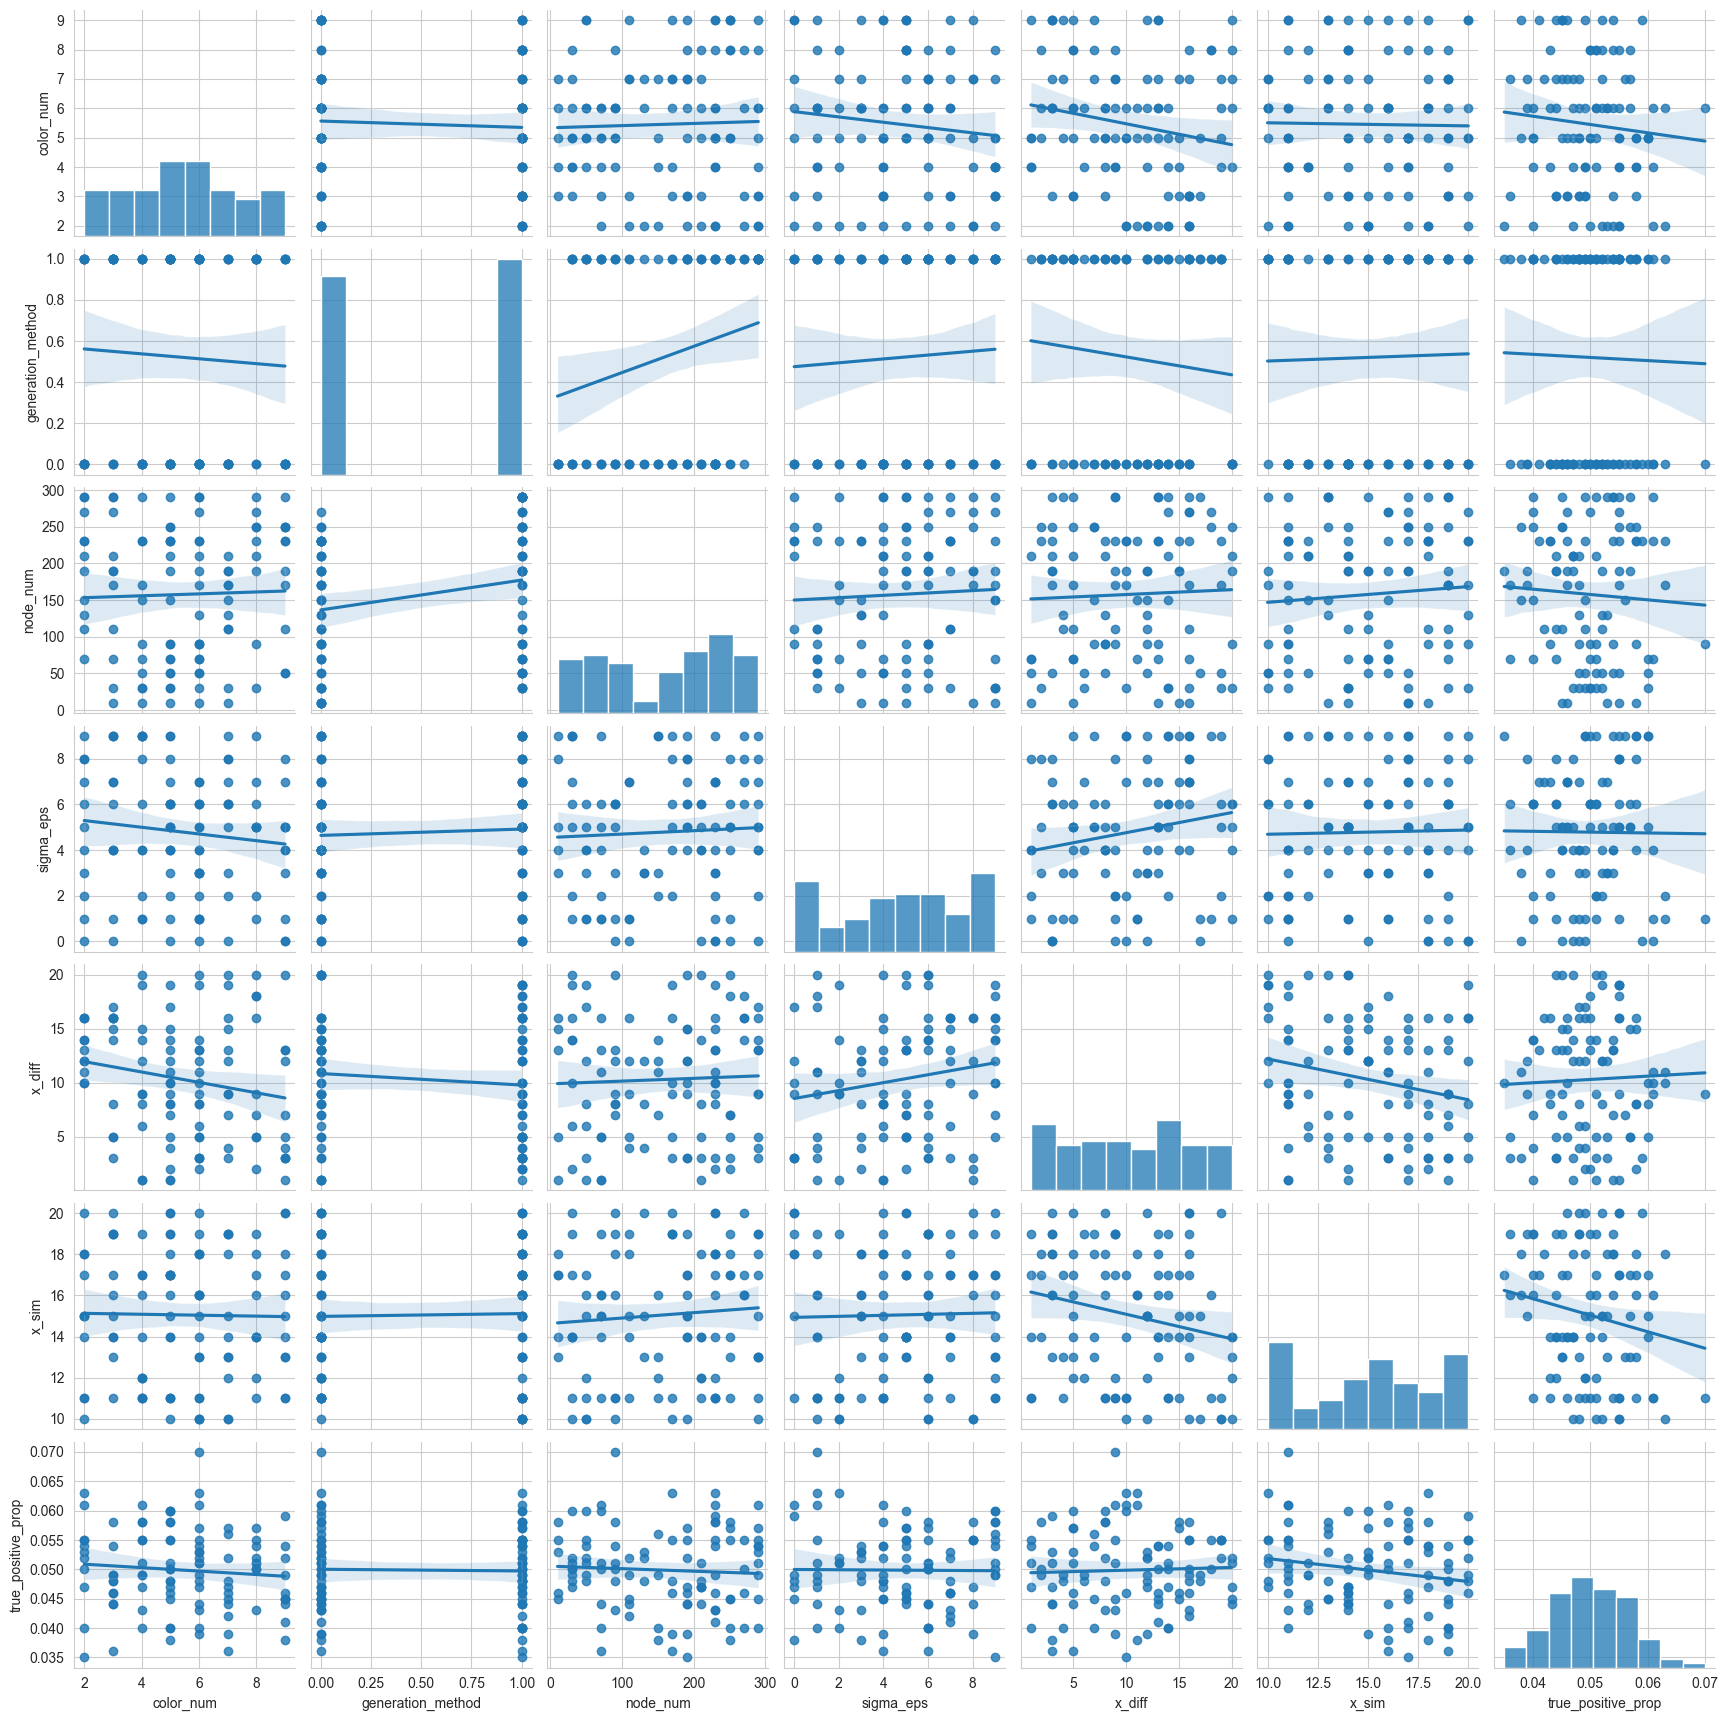

In [30]:
sns.pairplot(num_df, kind="reg")
plt.show()

Note that when the p-values are uniform and random, the bottom row has flat regression lines and a normal distribution of true positive proportions with a mean of 0.05 as expected. This shows our validation pipeline should work as expected.

In [44]:
theor_SE = np.sqrt((0.05 * 0.95) / 1000)
obs_SE = np.std(df["true_positive_prop"])

print(f"Theoretical SE: {theor_SE}; Observed SE: {obs_SE}.")

Theoretical SE: 0.006892024376045111; Observed SE: 0.0068664037166481845.


In [32]:
#spearman is non-parametric: uses ranks
num_df.corr("spearman")

,color_num,generation_method,node_num,sigma_eps,x_diff,x_sim,true_positive_prop
color_num,1.000000,-0.052856,0.032523,-0.117340,-0.189061,-0.023036,-0.107094
generation_method,-0.052856,1.000000,0.245173,0.063846,-0.091009,0.021954,0.010413
node_num,0.032523,0.245173,1.000000,0.041528,0.040955,0.077494,-0.033188
sigma_eps,-0.117340,0.063846,0.041528,1.000000,0.195384,0.021816,0.032981
x_diff,-0.189061,-0.091009,0.040955,0.195384,1.000000,-0.208886,0.028485
x_sim,-0.023036,0.021954,0.077494,0.021816,-0.208886,1.000000,-0.143573
true_positive_prop,-0.107094,0.010413,-0.033188,0.032981,0.028485,-0.143573,1.000000
